In [1]:
from keras.models import load_model
import keras.backend as K

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.metrics import explained_variance_score
from sklearn.utils.multiclass import unique_labels
import sklearn.metrics

import scipy

Using TensorFlow backend.


# 1. Global Parameters

In [2]:
IMAGE_SHAPE = (200, 200, 1)
NUM_LABELS = 5
BINS_EDGE = np.load("./data/bins_edge.npy")
NUM_CLASSES = len(BINS_EDGE) - 1  

# 2. Helper Functions

In [3]:
def one_hot_to_angle(one_hot_arr):
    """
    Decode 1 one hot encoded vector to get angle

    Input:
        one_hot_arr (np.ndarray): shape (1, NUM_CLASSES)
        bins_edge (np.ndarray): shape (1, NUM_CLASSES + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (BINS_EDGE[angle_id] + BINS_EDGE[angle_id + 1]) / 2.
    else:
        return BINS_EDGE[angle_id]


def id_to_angle(one_hot_arr):
    """
    Decode a matrix of one_hot vector (each vector is a row)
    """
    angles = np.zeros(one_hot_arr.shape[0])
    for i in range(len(angles)):
        angles[i] = one_hot_to_angle(one_hot_arr[i, :])
    return angles


def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean(np.square(y_hat - y)))


def plot_hist(y, y_hat, ax, title):
    """
    Plot histogram of y & y_hat in the same figure
    """
    _, _, _ = ax.hist(y, bins=BINS_EDGE, label="true")
    _, _, _ = ax.hist(y_hat, bins=BINS_EDGE, label="predict")
    ax.set_title(title)
    ax.legend(loc="upper right")
    

# 3. Performance of Network Trained by Regression

In [4]:
# Load model
regressor = load_model("./best_weights/regress_s1p5_2019_08_01_14_22.h5")
print("Loaded regressor from disk")
# model.summary()

# Load data
X_val = np.load('./data/regress_CH2_validation_X.npy')
y_val = np.load('./data/regress_CH2_validation_y.npy')
y_val = y_val[:, : NUM_LABELS]

# Generate prediction
y_hat = regressor.predict(X_val, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loaded regressor from disk
2360/2360 [==============================] - 10s 4ms/step


## 3.1 Qualitative Perfomance

In [7]:
rmse_seq = []
eva_seq = []
kl_div_seq = []

for i in range(NUM_LABELS):
    y_hat_value = y_hat[:, i]
    y_value = y_val[:, i]
    # calculate RMSE, EVA, & KL Divergence
    rmse_seq.append(root_mean_squared_error(y_value, y_hat_value))
    eva_seq.append(explained_variance_score(y_value, y_hat_value))
    kl_div_seq.append(scipy.stats.entropy(y_hat_value, y_value))
    
# Display
print("Regression network's qualitative performance")
print("\t\t RMSE \t\t EVA \t\t KL Div")
for i in range(NUM_LABELS):
    print("Pred %d: \t %.4f \t %.4f \t %.4f" % (i, rmse_seq[i], eva_seq[i], kl_div_seq[i]))

Regression network's qualitative performance
		 RMSE 		 EVA 		 KL Div
Pred 0: 	 0.1490 	 0.7177 	 inf
Pred 1: 	 0.1394 	 0.7482 	 inf
Pred 2: 	 0.1369 	 0.7553 	 inf
Pred 3: 	 0.1372 	 0.7542 	 inf
Pred 4: 	 0.1397 	 0.7454 	 inf


## 3.2 Angle Distribution

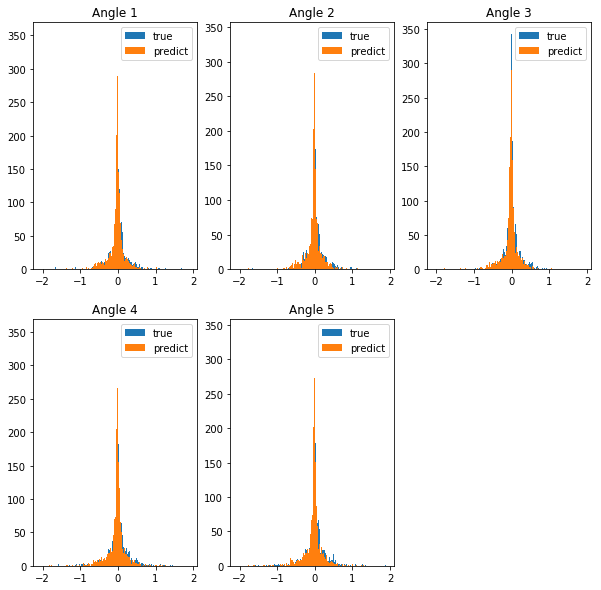

In [8]:
f = plt.figure(figsize=(10, 10))
f.tight_layout()

ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    plot_hist(y_val[:, i], y_hat[:, i], ax, "Angle %d" % (i + 1))


In [12]:
del regressor

# 4. Performance of Network Trained by Classification

In [4]:
# Load model
if NUM_LABELS > 1:
    classifier = load_model("./best_weights/s1p5_2019_07_31_09_24.h5")
else:
    classifier = load_model("./best_weights/s1p1_2019_08_06_12_47.h5")
print("Loaded classifier from disk")
# model.summary()

# Load data
X_val = np.load('./data/CH2_validation_X.npy')
y_val_arr = np.load('./data/CH2_validation_y.npy')
y_val = [y_val_arr[i, ...] for i in range(NUM_LABELS)]

# Generate prediction
y_hat = classifier.predict(X_val, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loaded classifier from disk
2360/2360 [==============================] - 4s 2ms/step


## 4.1 Qualitative Perfomance

In [5]:
if NUM_LABELS == 1:
    y_hat = [y_hat]

In [6]:
rmse_seq = []
eva_seq = []
kl_div_seq = []

for i in range(NUM_LABELS):
    # Get one-hot vector
    y_id = y_val[i]
    y_hat_id = y_hat[i]
    # Convert angle ID to angle value
    y_value = id_to_angle(y_id)
    y_hat_value = id_to_angle(y_hat_id)
    # calculate RMSE, EVA, & KL Divergence
    rmse_seq.append(root_mean_squared_error(y_value, y_hat_value))
    eva_seq.append(explained_variance_score(y_value, y_hat_value))
    kl_div_seq.append(scipy.stats.entropy(y_hat_value, y_value))
    
# Display
print("Regression network's qualitative performance")
print("\t\t RMSE \t\t EVA \t\t KL Div")
for i in range(NUM_LABELS):
    print("Pred %d: \t %.4f \t %.4f \t %.4f" % (i, rmse_seq[i], eva_seq[i], kl_div_seq[i]))

Regression network's qualitative performance
		 RMSE 		 EVA 		 KL Div
Pred 0: 	 0.1083 	 0.8338 	 inf


## 4.2 Angle ID distribution

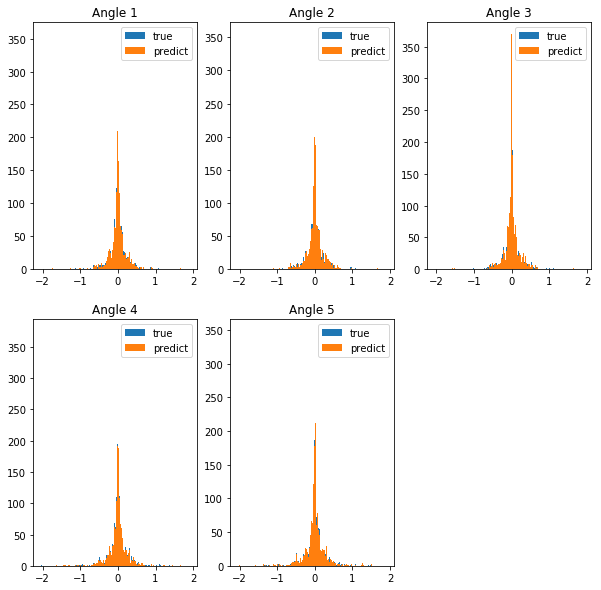

In [6]:
f = plt.figure(figsize=(10, 10))
f.tight_layout()

ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    # Get one-hot vector
    y_id = y_val[i]
    y_hat_id = y_hat[i]
    # Convert angle ID to angle value
    y_value = id_to_angle(y_id)
    y_hat_value = id_to_angle(y_hat_id)
    plot_hist(y_value, y_hat_value, ax, "Angle %d" % (i + 1))

plt.savefig("./images/predicted_angles_distribution.png")

# 5. Checkout layers' activation

In [ ]:
# Define intermediate model to get intermediate layer output
layer_list = ['feature_map_0', 'feature_map_1', 'feature_map_2']
intermediate_layer_model = Model(inputs=classifier.input,
                                 outputs=[model.get_layer(layer_name).output for layer_name in layer_list])


In [ ]:
# randomly choose 10 images from validation set to visualize layers' activation 
X_vis = X_val[np.random.randint(0, high=X_val.shape[0], size=10), ...]

# Get intermediate output with test images 
intermediate_output = intermediate_layer_model.predict(X_vis, verbose=1)

In [ ]:
print("type of intermediate_output: ", type(intermediate_output))
print("len intermediate_output: ", len(intermediate_output))
print("shape of first feature map:", intermediate_output[0].shape)

In [ ]:
nrow = 10
ncol = 4

fig = plt.figure(figsize=(40, 40))

gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1, 1],
         wspace=0., hspace=0.1, top=0.95, bottom=0.05, left=0.17, right=0.845)

for row in range(nrow):
    for col in range(ncol):
        ax= plt.subplot(gs[row, col])
        if col == 0:
            im = X_vis[row, ...].squeeze()
            ax.imshow(im, cmap='gray')
        else:
            feature_map = intermediate_output[col-1][row, ...]
            ax.imshow(feature_map[:, :, 0], cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.savefig("./images/layers_activation.png")
plt.show()

# 6. Confusion matrix

In [7]:
# Convert 1st prediction into class ID
y_val_1 = np.argmax(y_val[0], axis=1)
y_hat_1 = np.argmax(y_hat[0], axis=1)

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        norm_factor = cm.sum(axis=1)[:, np.newaxis]
        norm_factor[norm_factor == 0] = 1
        cm = cm.astype('float') / norm_factor
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(50,50))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,)
    ax.set_ylabel('True label', fontsize=30)
    ax.set_xlabel('Predicted label', fontsize=30)
           
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


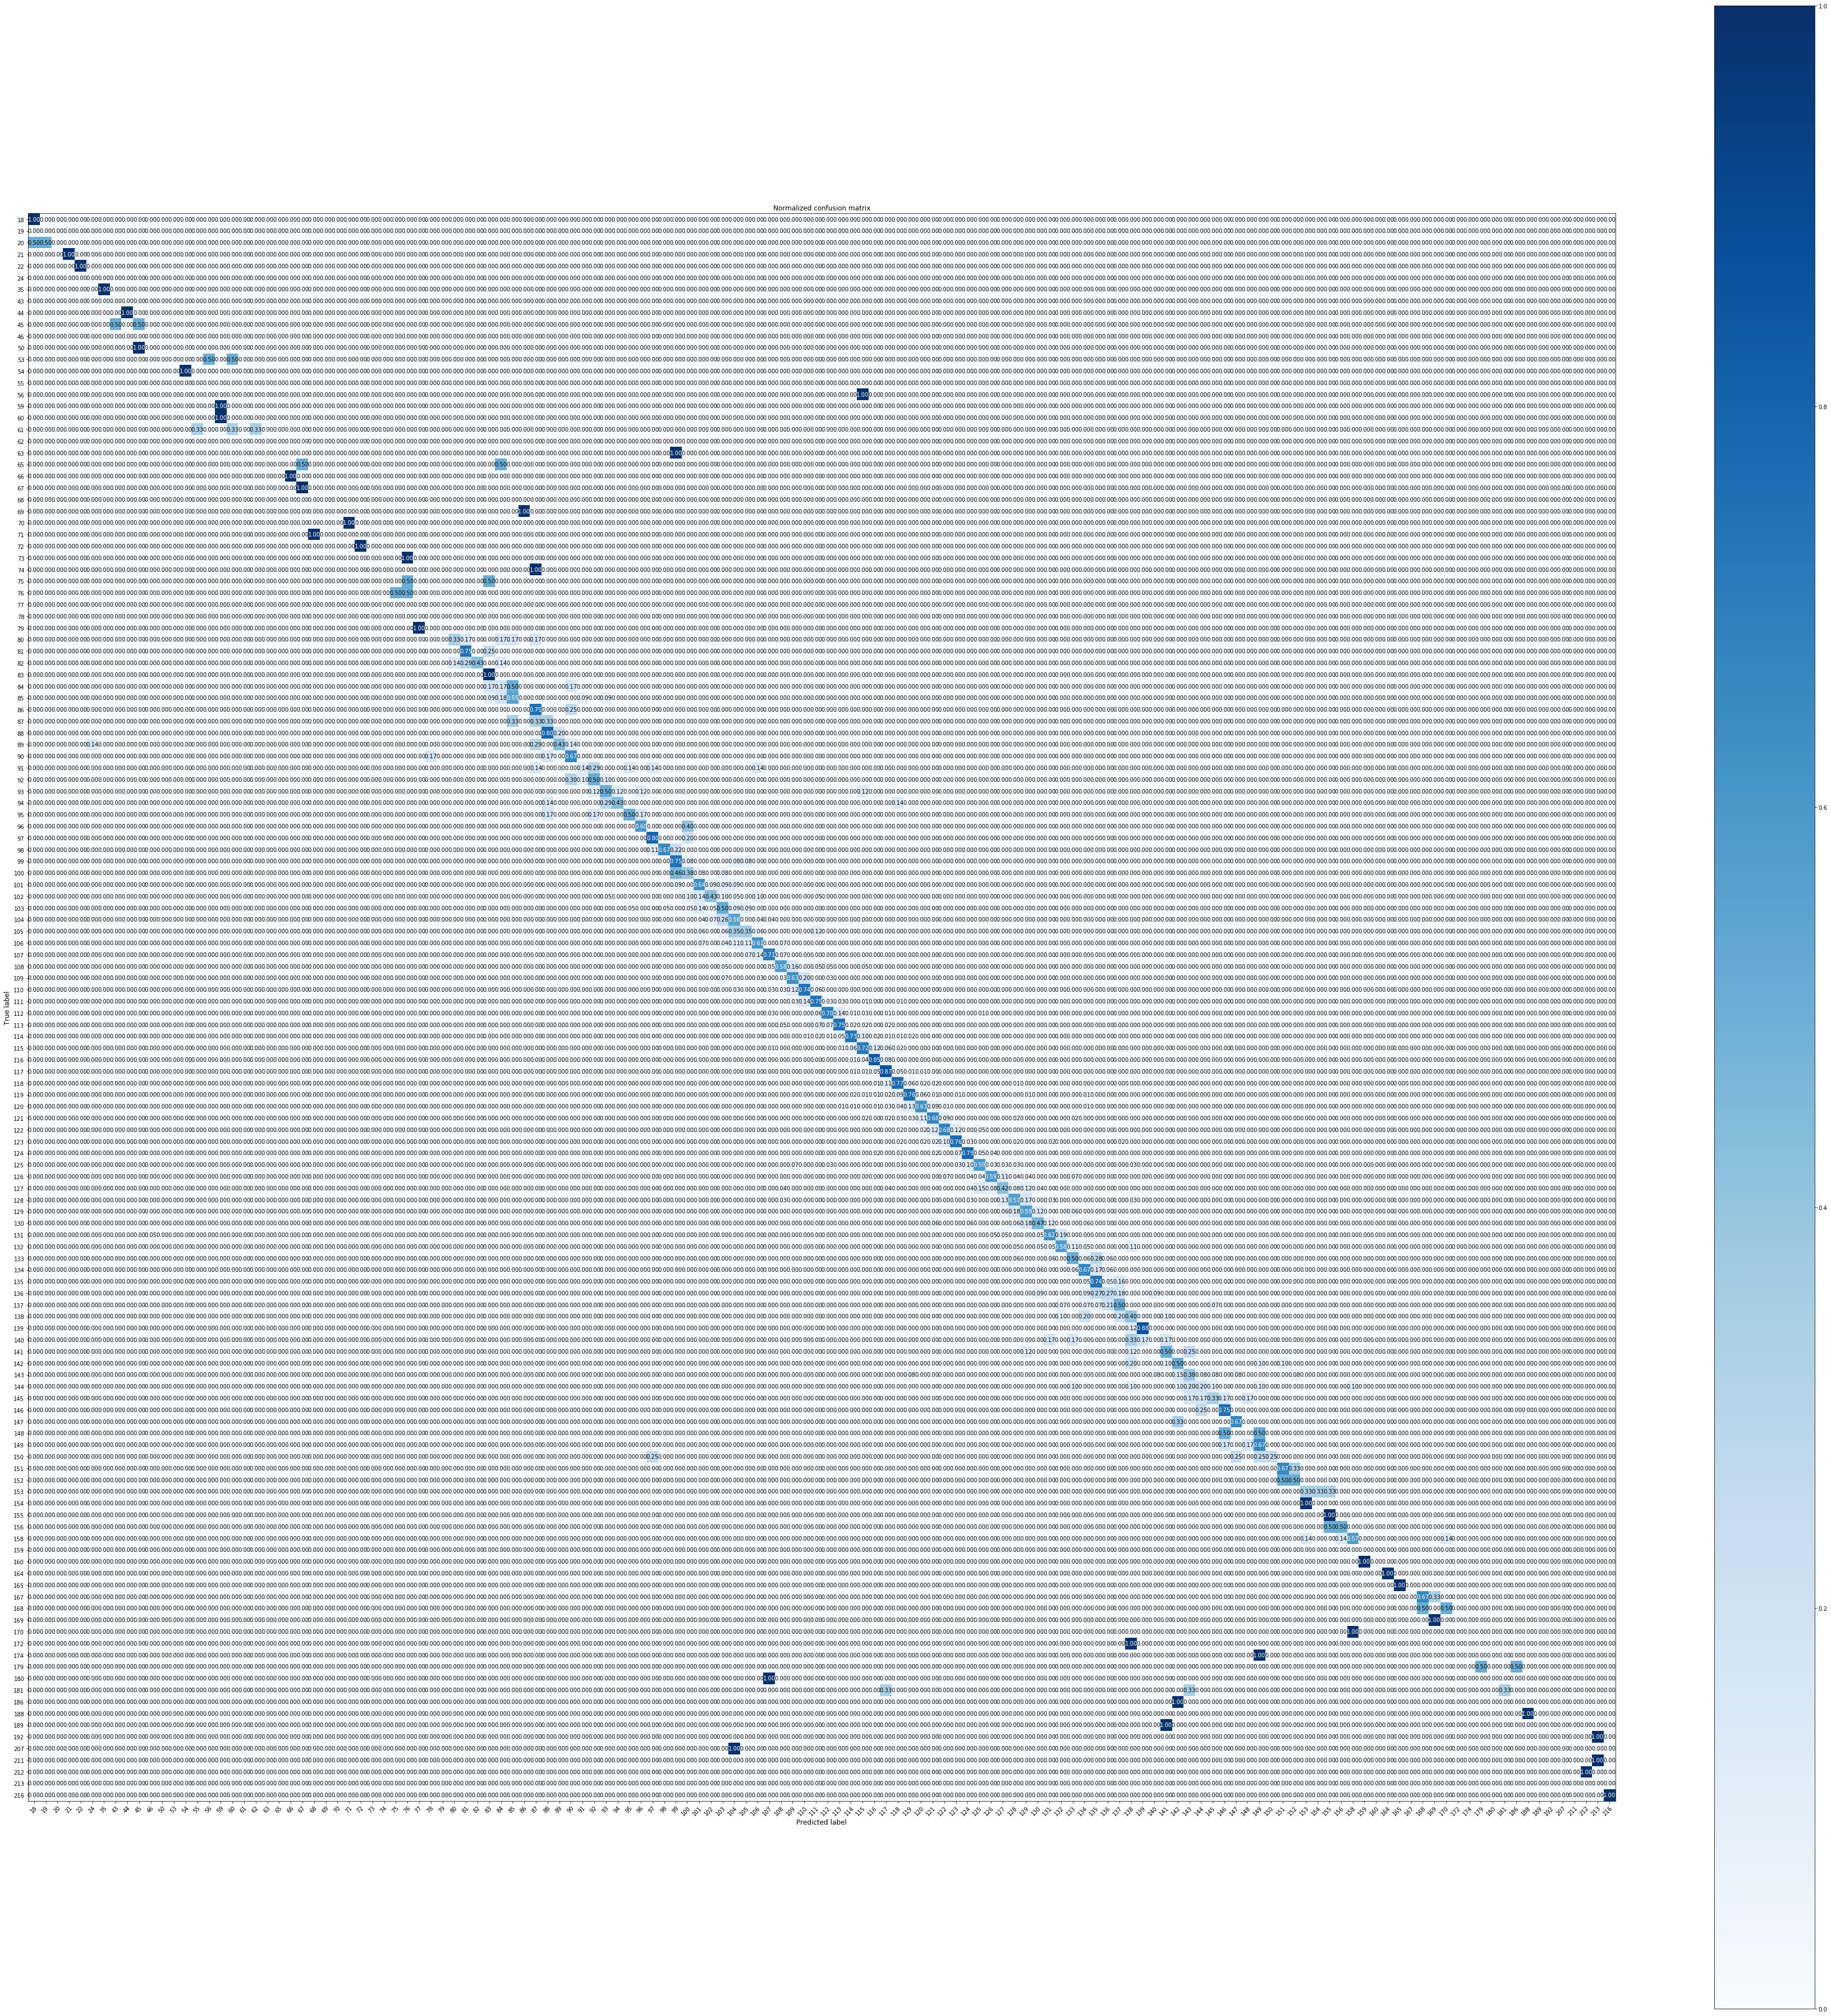

In [10]:
class_names = np.array([str(i) for i in range(227)])
plot_confusion_matrix(y_val_1, y_hat_1, class_names, normalize=True)
plt.savefig("./images/unnorm_confusion_matrix.png")